In [1]:
#standard imports
import numpy as np
import pandas as pd
import math
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import PLtools
import time
import matplotlib.cm as cm
import matplotlib as mpl
from os import listdir
%matplotlib inline

#change default plot settings
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

#Constants
pi = math.pi
heV = 4.14e-15 #eV*s
c = 2.99792e8 #m/s
kbeV = 8.6173e-5 #eV/K
keV = 8.6173e-5 #eV/K
h = 6.626e-34
kb = 1.38065e-23
q = 1.60218e-19

In [2]:
#Inputs Here
directory = '2018_8-7PL'
laser_power = 32*1e-9
grating = '500nm' # '500nm' or '1200nm'
#dname = 'Dark.txt' #assumes 1 dark name per folder

names = []
for file in listdir(directory):
    if file[-6:] == 'XY.txt':
        names.append(file)
    elif file[-8:] == 'Dark.txt':
        dname = file

In [34]:
DiodeReadings_1sun = laser_power
DiodeResponse532= 0.2741
Area785ImageJ = pi*(6.01e-6)**2
Ep532 = 2.3305 #E per photon @532

#Load data from Mathmatica calcs to determine SQ limits @ 300 K and 350 K for various
#Egs

#fix this section later for generalized T
Egs = np.loadtxt('../../data/PLdata/vocmax_data/Egs.txt')
VocSQs300 = np.loadtxt('../../data/PLdata/vocmax_data/VocMaxs.txt') # 300 K
Jphs = np.loadtxt('../../data/PLdata/vocmax_data/Jphs.txt') #300 K
VocSQs350 = np.loadtxt('../../data/PLdata/vocmax_data/VocMaxs2.txt') # 350 K
VocSQs300_fn = interp1d(Egs, VocSQs300, kind='cubic')
VocSQs350_fn = interp1d(Egs, VocSQs350, kind='cubic')
Jphs_fn = interp1d(Egs, Jphs, kind='cubic')

df = pd.read_table(directory + '/' + dname,header=None)
dark = df.values

df = pd.read_table(directory + '/' + names[0],header=None)
data = df.values
    
spectra = data.shape[0]-1;
samples = len(names)

data_out = np.zeros([spectra,len(names),7])
med_idxs = np.zeros(samples)
Es_out = np.zeros([1024,samples])
aipl_out = np.zeros([1024,samples])

for jj in range(len(names)):
    df = pd.read_table(directory + '/' + names[jj],header=None)
    data = df.values
    AIPL = PLtools.aipl(data,dark,grating)

    aipl_data = AIPL




    DiodeReading = DiodeReadings_1sun
    P532 = DiodeReading/(DiodeResponse532*Area785ImageJ*10) #W/m^2
    Jp532 = DiodeReading*0.925/(DiodeResponse532*Area785ImageJ*1.60218e-19*Ep532*2)

    
    k = 0
    while np.isnan(aipl_data[0,k]):
        k = k + 1
    lam = aipl_data[0,k:]
    E = heV*c/(lam*1e-9)
    mean_Ipl = np.zeros(aipl_data.shape[0])
    peak_pos = np.zeros(aipl_data.shape[0])
    FWHM = np.zeros(aipl_data.shape[0])
    PLQY = np.zeros(aipl_data.shape[0])
    dmu_PLQY = np.zeros(aipl_data.shape[0])
    chi_PLQY = np.zeros(aipl_data.shape[0])
    dmu_PLQY_Eg = np.zeros(aipl_data.shape[0])
    chi_PLQY_Eg = np.zeros(aipl_data.shape[0])
    for ii in range(1,aipl_data.shape[0]-1):
        Ipl = aipl_data[ii,k:]
        maxI = np.max(Ipl)
        maxI_idx = np.argmax(Ipl)
        peak_pos[ii-1] = E[maxI_idx]
        HHMax_idx = np.argmin(np.absolute(maxI/2-Ipl[:maxI_idx]))
        LHMax_idx = np.argmin(np.absolute(maxI/2-Ipl[maxI_idx:]))
        LHMax_idx = LHMax_idx+maxI_idx-1
        FWHM[ii-1] = E[HHMax_idx]-E[LHMax_idx]
        try:
            VocSQ300 = VocSQs300_fn(E[maxI_idx])
            VocSQ350 = VocSQs350_fn(E[maxI_idx])
            JphSQ = Jphs_fn(E[maxI_idx])
            NSuns = Jp532*q/JphSQ;
            VocMax300 = VocSQ300 + kb*300/q*np.log(Jp532*q/JphSQ)
            VocMax350 = VocSQ350 + kb*350/q*np.log(Jp532*q/JphSQ)
            TotalPL = np.mean(-E[1:-1]+E[0:-2])/2*(Ipl[0]+Ipl[-1]+2*np.sum(Ipl[1:-2]))
            TotalPL_Eg = np.mean(-E[1:maxI_idx]+E[0:maxI_idx-1])/2*(Ipl[0]+Ipl[maxI_idx]+2*np.sum(Ipl[1:maxI_idx-1]))
            PLQY[ii-1] = TotalPL/Jp532
            dmu_PLQY[ii-1] = VocMax350-kbeV*350*np.log(1/PLQY[ii-1])
            chi_PLQY[ii-1] = dmu_PLQY[ii-1]/VocMax300 
            chi_PLQY_Eg[ii-1] = (VocMax350-kbeV*350*np.log(1/(TotalPL_Eg/Jp532)))/VocMax300
            PLQY_Eg = TotalPL_Eg/Jp532
            dmu_PLQY_Eg[ii-1] = VocMax350-kbeV*350*np.log(1/(TotalPL_Eg/Jp532))
            mean_Ipl[ii-1] = np.sum(Ipl*E)/np.sum(Ipl)
        except ValueError:
            VocSQ300 = 0
            VocSQ350 = 0
            JphSQ = 0
            NSuns = 1    
        
        data_out[:,jj,0] = peak_pos[:-1]
        data_out[:,jj,1] = PLQY[:-1]
        data_out[:,jj,2] = dmu_PLQY[:-1]
        data_out[:,jj,3] = chi_PLQY[:-1]
        data_out[:,jj,4] = dmu_PLQY_Eg[:-1]
        data_out[:,jj,5] = chi_PLQY_Eg[:-1]
        data_out[:,jj,6] = mean_Ipl[:-1]
        med_idxs[jj] = np.argsort(PLQY)[len(data)//2]
        Es_out[:,jj] = E
        aipl_out[:,jj] = aipl_data[int(med_idxs[jj]),k:]





C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log
C:\Users\Ryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log


In [50]:
names

['2018_8-7 FAGACs_1o25PEAI_1Sun_XY.txt',
 '2018_8-7 FAGACs_1p25FASCN_1Sun_XY.txt',
 '2018_8-7 FAGACs_1Sun_XY.txt',
 '2018_8-7 FAGACs_2p5FASCN_1Sun_XY.txt',
 '2018_8-7 FAGACs_2p5PEAI_1Sun_XY.txt',
 '2018_8-7 FAGACs_2p5PEAI_2p5FASCN_1Sun_XY.txt',
 '2018_8-7 FAGACs_3p75FASCN_1Sun_XY.txt',
 '2018_8-7 FAGACs_3p75PEAI_1Sun_XY.txt',
 '2018_8-7 FAGACs_5FASCN_1Sun_XY.txt',
 '2018_8-7 FAGACs_5PEAI_1Sun_XY.txt']

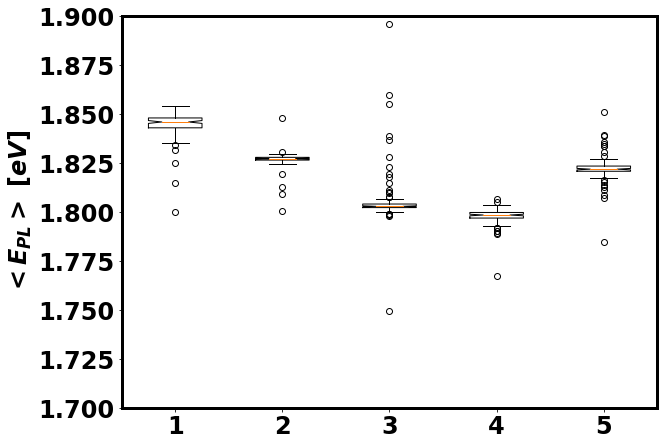

In [53]:
#plots

#Why is last row 0? something to consider
#need to filter data incase of nan, use list
data_filtered = []
for ii in (2,1,3,6,8):
    data_in = data_out[:-1,ii,6]
    data_filtered.append(data_in[~np.isnan(data_in)])
plt.boxplot(data_filtered)
plt.ylim(1.7,1.9)
plt.ylabel('$<E_{PL}>\ [eV]$')

{'boxes': [<matplotlib.lines.Line2D at 0x170aa7e7ef0>,
 'caps': [<matplotlib.lines.Line2D at 0x170aa7fb908>,
 'fliers': [<matplotlib.lines.Line2D at 0x170aa802b38>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x170aa802320>,
 'whiskers': [<matplotlib.lines.Line2D at 0x170aa7f3898>,
  <matplotlib.lines.Line2D at 0x170aa8e2ba8>]}

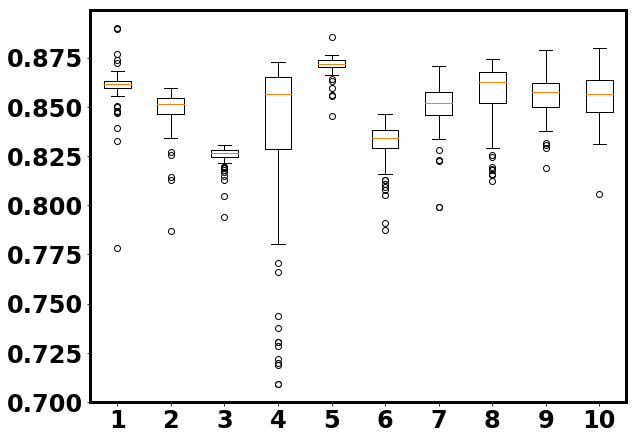

In [49]:
data_filtered = []
for ii in range(samples):
    data_in = data_out[:-1,ii,5]
    data_filtered.append(data_in[~np.isnan(data_in)])
plt.boxplot(data_filtered)


In [48]:
data_filtered

[array([ 0.85731557,  0.85639739,  0.85656703,  0.85632653,  0.8497948 ,
         0.83924471,  0.84724478,  0.77810284,  0.83270936,  0.85019234,
         0.86740321,  0.85551074,  0.85717258,  0.85964081,  0.85999863,
         0.85894718,  0.85854904,  0.86086409,  0.86258875,  0.86327172,
         0.8631232 ,  0.85836153,  0.85810803,  0.85847212,  0.86326552,
         0.86595829,  0.86387923,  0.86529165,  0.8621643 ,  0.86146056,
         0.86296589,  0.86193578,  0.86169808,  0.86057555,  0.85945196,
         0.85613629,  0.86199363,  0.86028475,  0.86271806,  0.86073297,
         0.86187342,  0.86347063,  0.86214016,  0.86358073,  0.86328445,
         0.84778379,  0.85841076,  0.86212031,  0.86084479,  0.86184826,
         0.86156056,  0.86602196,  0.86214356,  0.85922555,  0.86289008,
         0.86187399,  0.8575676 ,  0.85561932,  0.86393031,  0.86501004,
         0.86341457,  0.86196378,  0.86427148,  0.86131169,  0.86397056,
         0.86309506,  0.85982787,  0.85747466,  0.8

In [45]:
data_out[:-1,3,5]

array([ 0.84766722,  0.85784953,  0.83212082,  0.85861684,  0.87195645,
        0.87298748,  0.86834217,  0.84456994,  0.86819337,  0.85782488,
        0.85694898,  0.85564766,  0.86052194,  0.86767612,  0.86291704,
        0.86377285,  0.86064737,  0.86688404,  0.86809179,  0.86038045,
        0.86572217,  0.84973171,  0.85747025,  0.85809091,  0.844126  ,
        0.86822931,  0.86965652,  0.86625931,  0.86797306,  0.85887529,
        0.86580525,  0.85848488,  0.86058066,  0.86781852,  0.86832975,
        0.86636559,  0.86851785,  0.86519821,  0.86796496,  0.86635728,
        0.85651405,  0.86270762,  0.85498093,  0.86118409,  0.85670648,
        0.8566322 ,  0.8582299 ,  0.85710383,  0.8624523 ,  0.86564542,
        0.8607676 ,  0.86584001,  0.85466804,  0.829969  ,  0.83313799,
        0.79833063,  0.8283531 ,  0.80127039,  0.8202155 ,  0.847049  ,
        0.83144568,  0.80206227,  0.78615802,  0.78016132,  0.84662813,
        0.81903512,  0.84915814,  0.7807487 ,  0.79387319,  0.80